In [30]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
from decimal import Decimal
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

$\sum_{i=1}^{\infty} \frac{1}{i}$

Sigmoid Activation Function
$\sigma(x)=\frac{1}{1+e^{-x}}$

<img src="./images/sigmoid.png" style="float: left; margin-right: 10px;" />

In [12]:
def sigmoid(z):
    g = np.zeros(z.shape)
    g = expit(z)
    return g

In [13]:
def sigmoidGradient(z):
    g = sigmoid(z)
    g = g*(1-g)
    return g

In [14]:
def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure(figsize=(16,16))
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    plt.set_cmap("gray")
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array.T, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

In [28]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0]
    p = np.zeros((m,1))
    X = np.column_stack((np.ones((m,1)), X))
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    p = np.argmax(a3, axis=1)
    return p + 1

Feed forward network

<img src='./images/ann.jpg'>

* Add a column of 1 to the $X$  matrix to account for the bias term and then $A=\sigma(X\Theta^{(1)})$
* Add a column of 1 to the $A$  matrix to account for the bias term and then $H_{\Theta}=\sigma(A\Theta^{(2)})$

<b>Cost Function</b>

$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{i=1}^{K}[y_{k}^{(i)} log((H_{\Theta}(x^{(i)}))_{k}) + (1-y_{k}^{(i)}) log(1-(H_{\Theta}(x^{(i)}))_{k})+\frac{\lambda}{2m}\sum_{l=1}^{2}\sum_{i=1}^{sl} (\Theta_{j,i}^{(l)})^{2}]$

<b>Back Propagation</b>

The cost function $J(\Theta)$ is minimized using the Back Propagation algorithm which gives the optimal values for $\Theta^{(1)}$ and $\Theta^{(2)}$

In [16]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
	num_labels, X, y, lambda_reg):
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )

    labels = y
    #One hot encoding
    y = np.zeros((m,num_labels))
    for i in range(m):
    	y[i, labels[i]-1] = 1

    cost = 0
    for i in range(m):
    	cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )
    J = -(1.0/m)*cost
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))
    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )
    bigDelta1 = 0
    bigDelta2 = 0
    for t in range(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T))
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        for k in range(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m
    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    return J, grad

In [17]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init
    return W

In [27]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [19]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
_,input_layer_size  = X_train.shape  
hidden_layer_size = 25   # 25 hidden units
num_labels = 10

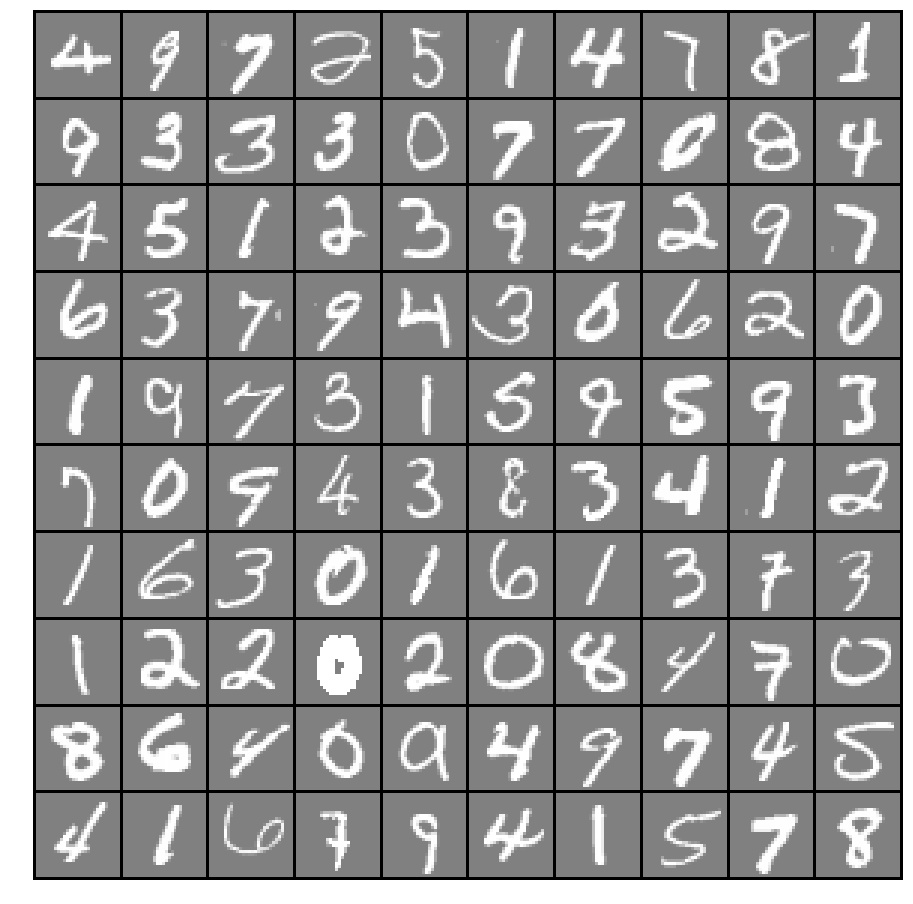

In [20]:
X=X_train
y=y_train
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);

In [21]:
Theta1=randInitializeWeights(input_layer_size,hidden_layer_size)
Theta2=randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))#

In [22]:
print('Training Neural Network...')
maxiter = 1000
lambda_reg = 0.1
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
results = minimize(nnCostFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1), order='F')

Training Neural Network...



Visualizing Neural Network layer 1 



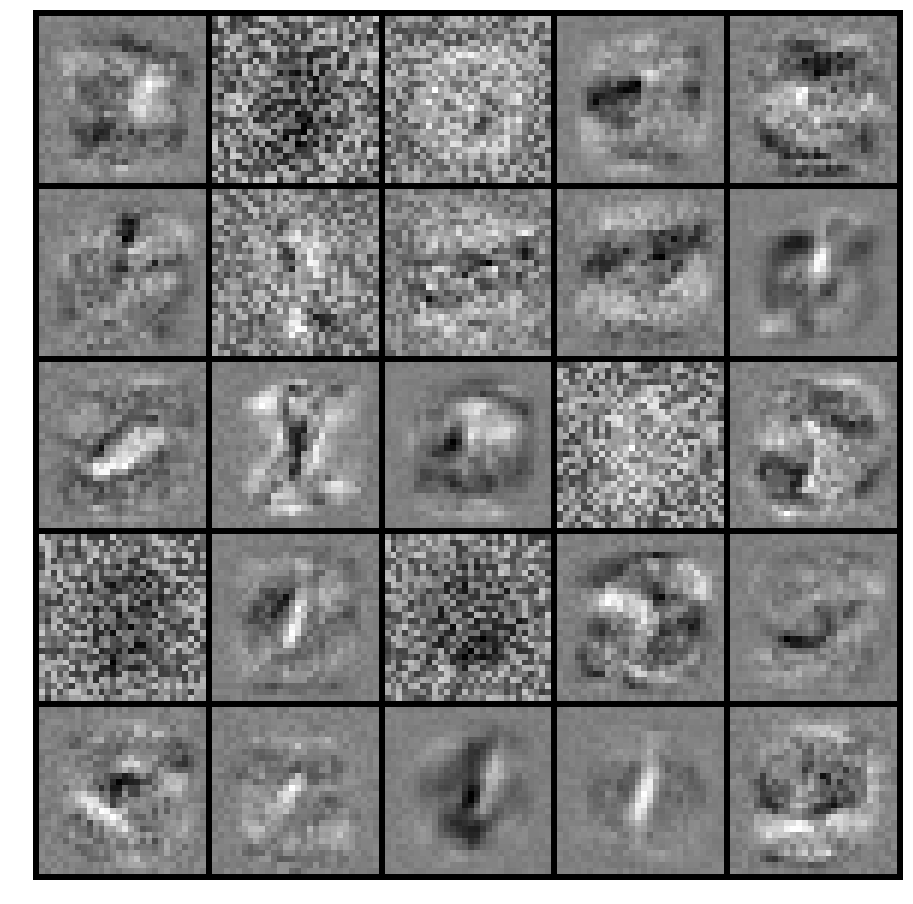

In [23]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta1[:, 1:]);


Visualizing Neural Network layer 1 



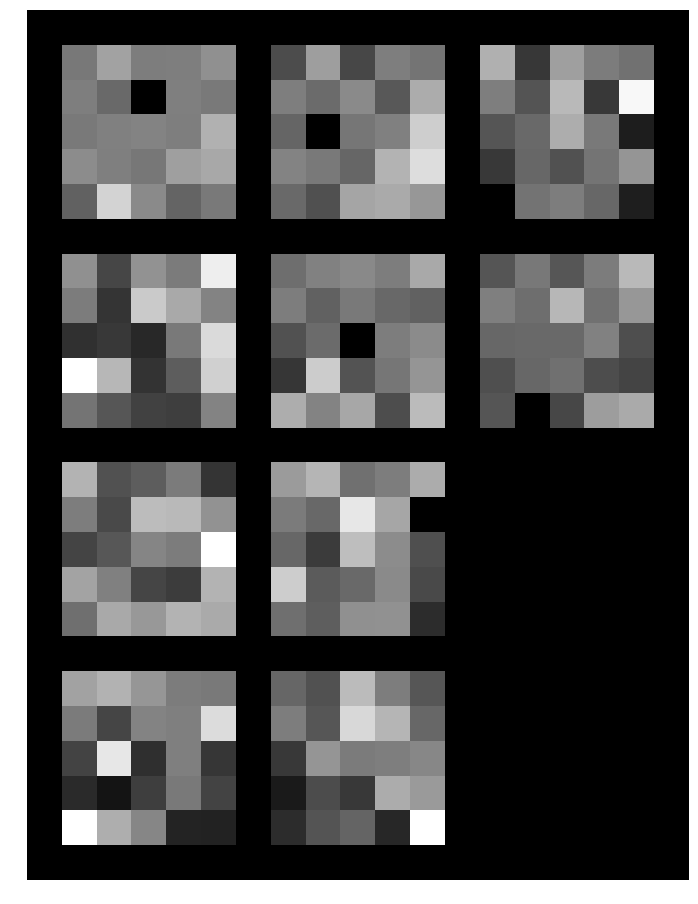

In [24]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta2[:, 1:]);

In [25]:
pred = predict(Theta1, Theta2, X)

In [26]:
# uncomment code below to see the predictions that don't match
# fmt = '{}   {}'
# print(fmt.format('y', 'pred'))
# for y_elem, pred_elem in zip(y, pred):
#     if y_elem != pred_elem:
#         print(fmt.format(y_elem%10, pred_elem%10))

print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )

#for i in range(m):
#    print('Displaying Example Image')
#    displayData(X[rp[i], :].reshape(1,-1))
#    pred = predict(Theta1, Theta2, X[rp[i], :])
#    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred%10)[0]))
#    input('Program paused. Press enter to continue.\n')

Training Set Accuracy: 83.115000


# Solve using Keras with Tensorflow backend

In [101]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt
from decimal import Decimal
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

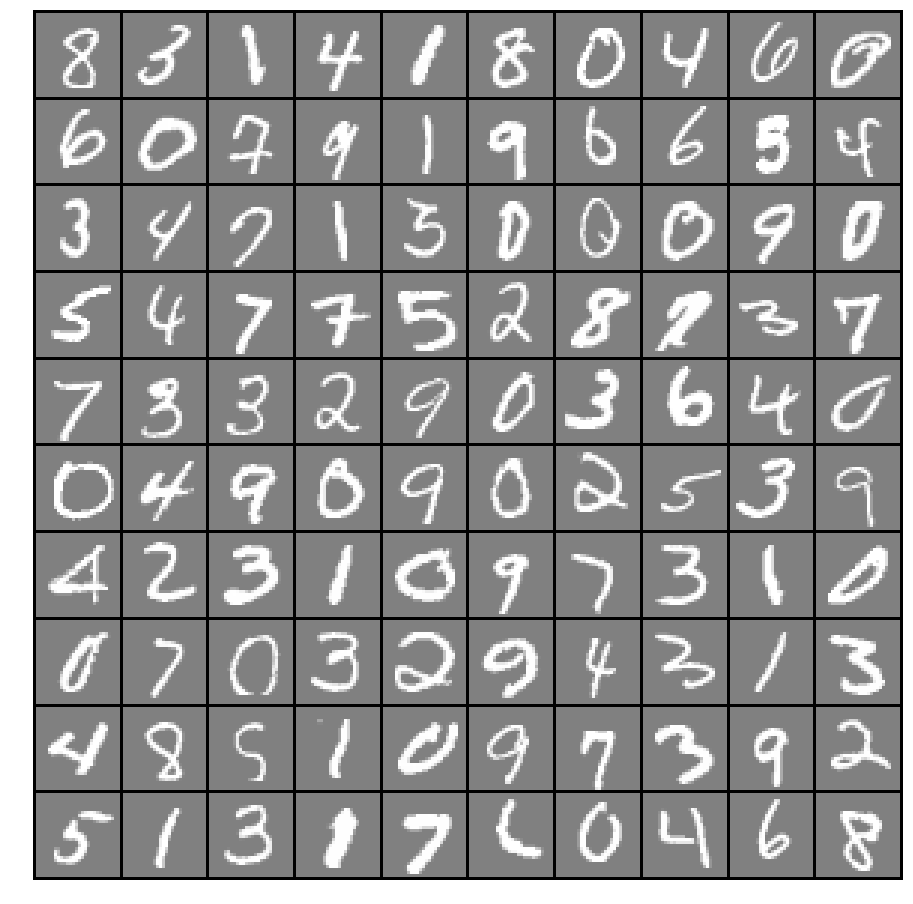

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
_,input_layer_size  = X_train.shape  
X=X_train
y=y_train
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);
num_labels=np.unique(y).shape [0]

In [50]:
#One hot encoding
y = np_utils.to_categorical(y)
print("Shape of y ",y.shape)

Shape of y  (60000, 10)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [53]:
ANN_classifier = Sequential()
ANN_classifier.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'relu', input_dim = input_layer_size))
ANN_classifier.add(Dense(units = num_labels, kernel_initializer = 'uniform', activation = 'softmax'))
ANN_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history=ANN_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100, epochs = 10)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s - loss: 0.6222 - acc: 0.8347 - val_loss: 0.2702 - val_acc: 0.9185
Epoch 2/10
54000/54000 [==============================] - 3s - loss: 0.2556 - acc: 0.9260 - val_loss: 0.2402 - val_acc: 0.9285
Epoch 3/10
54000/54000 [==============================] - 3s - loss: 0.2112 - acc: 0.9385 - val_loss: 0.2429 - val_acc: 0.9325
Epoch 4/10
54000/54000 [==============================] - 3s - loss: 0.1907 - acc: 0.9451 - val_loss: 0.2191 - val_acc: 0.9370
Epoch 5/10
54000/54000 [==============================] - 3s - loss: 0.1804 - acc: 0.9468 - val_loss: 0.2059 - val_acc: 0.9412
Epoch 6/10
54000/54000 [==============================] - 3s - loss: 0.1758 - acc: 0.9490 - val_loss: 0.1983 - val_acc: 0.9440
Epoch 7/10
54000/54000 [==============================] - 3s - loss: 0.1635 - acc: 0.9526 - val_loss: 0.2060 - val_acc: 0.9420
Epoch 8/10
54000/54000 [==============================] - 3s -

Displaying Example Image


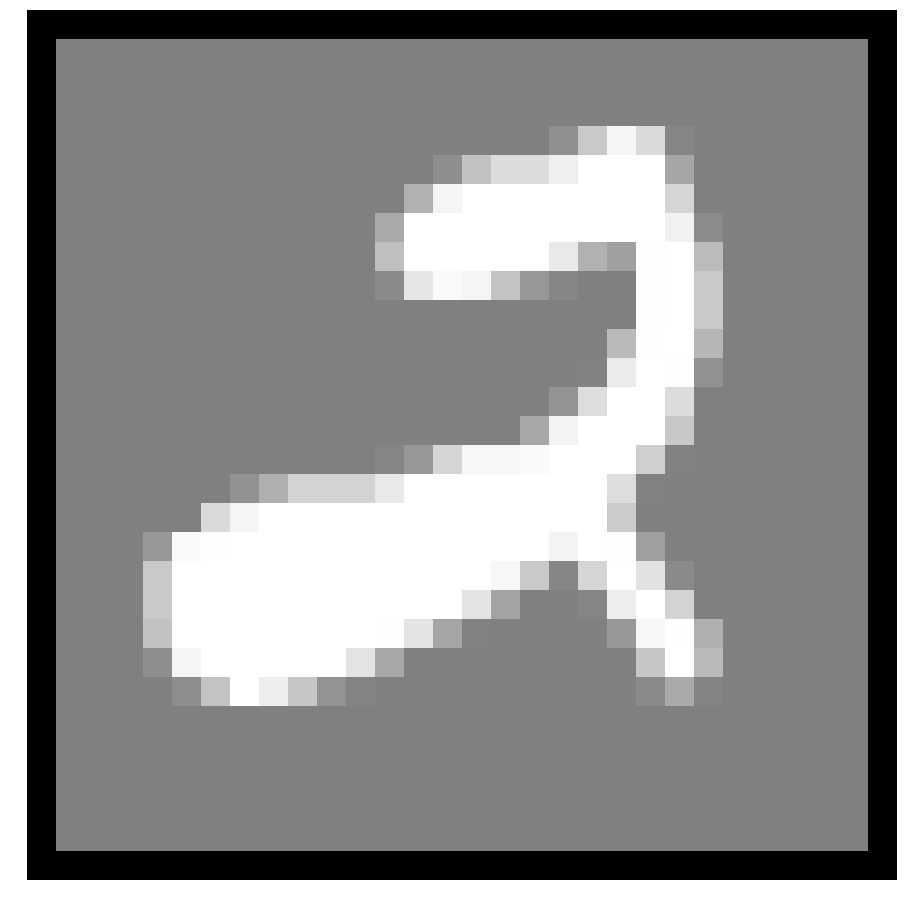

Neural Network Prediction:  2


In [ ]:
#Create randomized index
rp = np.random.permutation(len(X_test))
#Try out on the data
for i in range(3):
    print('Displaying Example Image')
    displayData(X_test[rp[i], :].reshape(1,-1))
    pred = ANN_classifier.predict(X_test[rp[i],:].reshape(1,-1))
    print('Neural Network Prediction: ',np.argmax(pred))
    input('Program paused. Press enter to continue.\n')
    